In [1]:
from math import pi
import numpy
%matplotlib inline
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family']='serif'
rcParams['font.size']=16
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numba
from numba import jit

In [2]:
def plot_3D(x,y,u):    
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,u[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$x$') 
    ax.set_ylabel('$y$')
    ax.set_zlabel('$u$')
    ax.view_init(30,45)

In [3]:
def plot_initial(ni,nj):
    u0=numpy.random.random((nj+1,ni+1))
    dx=1./(ni-1)
    dy=1./(nj-1)
    x=numpy.linspace(0-dx/2,1+dx/2,ni+1)
    y=numpy.linspace(0-dy/2,1+dy/2,nj+1)
    plot_3D(x,y,u0)

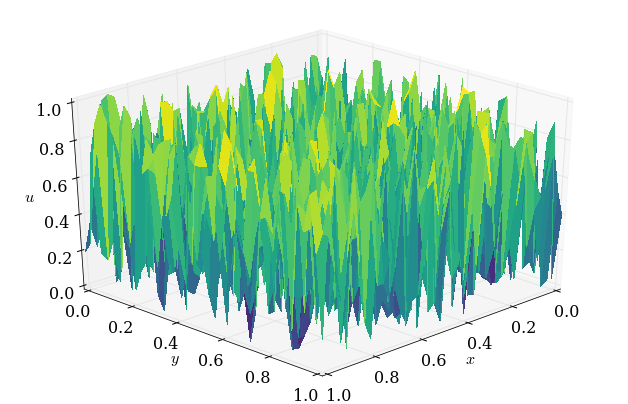

In [4]:
plot_initial(41,41)

In [5]:
@jit
def jacobi(ni,nj,n,res_target):
    dx=1./(ni-1) 
    dy=1./(nj-1)
    x=numpy.linspace(0-dx/2,1+dx/2,ni+1)
    y=numpy.linspace(0-dy/2,1+dy/2,nj+1)
    
    X,Y=numpy.meshgrid(x,y)
    f=-2*(2*pi*n)**2*numpy.cos(2*pi*n*X)*numpy.cos(2*pi*n*Y)
    u_ex=numpy.cos(2*pi*n*X)*numpy.cos(2*pi*n*Y)
    
    u0=numpy.random.random((nj+1,ni+1))
    u=u0.copy()
    
    iterations=0
    dif=numpy.zeros((nj+1,ni+1))
    err=numpy.zeros((nj+1,ni+1))
    res=numpy.zeros((nj+1,ni+1))
    res_max=1e3
    
    while res_max>res_target:
        uold=u.copy()
        #u[1:-1,1:-1]=1./(2*(dx**2+dy**2))*((uold[1:-1,2:]+uold[1:-1,:-2])*dy**2+\
                     #(uold[2:,1:-1]+uold[:-2,1:-1])*dx**2-f[1:-1,1:-1]*dx**2*dy**2)
        for j in range(1,nj):
            for i in range(1,ni):
                
                u[j,i]=1./(2*(dx**2+dy**2))*((uold[j,i+1]+uold[j,i-1])*dy**2+\
                           (uold[j+1,i]+uold[j-1,i])*dx**2-f[j,i]*dx**2*dy**2)
                    
        u[0,:]=2*numpy.cos(2*pi*n*x)-u[1,:]
        u[-1,:]=u[-2,:]
        u[:,0]=u[:,1]
        u[:,-1]=u[:,-2]
        
        for j in range(1,nj):
            for i in range(1,ni):
                res[j,i]=numpy.abs(f[j,i]-(u[j,i-1]-2*u[j,i]+u[j,i+1])/dx**2-\
                                  (u[j-1,i]-2*u[j,i]+u[j+1,i])/dy**2)
        res_max=numpy.max(res)
        iterations+=1
        
    for j in range(nj+1):
        for i in range(ni+1):
            dif[j,i]=numpy.abs(u[j,i]-uold[j,i])
            err[j,i]=numpy.abs(u[j,i]-u_ex[j,i])
    dif_max=numpy.max(dif)
    err_max=numpy.max(err)
    
    A=numpy.array([u,x,y,dif_max,err_max,res_max,iterations])
    return A

difference              error               residual           iterations
[1.5620837956475953e-13 0.0031535036348568912 9.995417826758057e-10 54886]


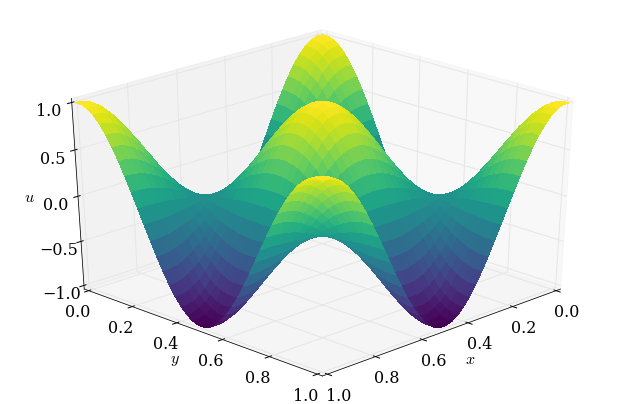

In [6]:
A40_jac1=jacobi(41,41,1,1e-9)
print('difference              error               residual           iterations')
print(A40_jac1[3:])
plot_3D(A40_jac1[1],A40_jac1[2],A40_jac1[0])

In [7]:
@jit
def SOR(ni,nj,n,res_target,omega):
    dx=1./(ni-1)
    dy=1./(nj-1)
    x=numpy.linspace(0-dx/2,1+dx/2,ni+1)
    y=numpy.linspace(0-dy/2,1+dy/2,nj+1)
    
    X,Y=numpy.meshgrid(x,y)
    f=-2*(2*pi*n)**2*numpy.cos(2*pi*n*X)*numpy.cos(2*pi*n*Y)
    u_ex=numpy.cos(2*pi*n*X)*numpy.cos(2*pi*n*Y)
    u0=numpy.random.random((nj+1,ni+1))
    u=u0.copy()
    u[0,:]=u_ex[0,:]
    u[-1,:]=u[-2,:]
    u[:,0]=u[:,1]
    u[:,-1]=u[:,-2]
    dif=numpy.zeros((nj+1,ni+1))
    err=numpy.zeros((nj+1,ni+1))
    res=numpy.zeros((nj+1,ni+1))
    res_max=1e3
    iterations=0
    
    while res_max>res_target:
        uold=u.copy()
        for j in range(1,nj):
            for i in range(1,ni):
                u[j,i]=omega/(2*(dx**2+dy**2))*((u[j,i-1]+u[j,i+1])*dy**2+\
                       (u[j-1,i]+u[j+1,i])*dx**2-f[j,i]*dx**2*dy**2)+\
                       (1-omega)*u[j,i]
                    
        u[0,:]=2*numpy.cos(2*pi*n*x)-u[1,:]
        u[-1,:]=u[-2,:]
        u[:,0]=u[:,1]
        u[:,-1]=u[:,-2]
        
        for j in range(1,nj):
            for i in range(1,ni):
                res[j,i]=numpy.abs(f[j,i]-(u[j,i-1]-2*u[j,i]+u[j,i+1])/dx**2-\
                                  (u[j-1,i]-2*u[j,i]+u[j+1,i])/dy**2)
        res_max=numpy.max(res)
        iterations+=1
        
    for j in range(nj+1):
        for i in range(ni+1):
            dif[j,i]=numpy.abs(u[j,i]-uold[j,i])
            err[j,i]=numpy.abs(u[j,i]-u_ex[j,i])
    
    dif_max=numpy.max(dif)
    err_max=numpy.max(err)
    
    A=numpy.array([u,x,y,dif_max,err_max,res_max,iterations])
    
    return A

difference              error               residual          iterations
[5.6532556413912971e-13 0.0031535036279647377 9.904397302307189e-10 2281]


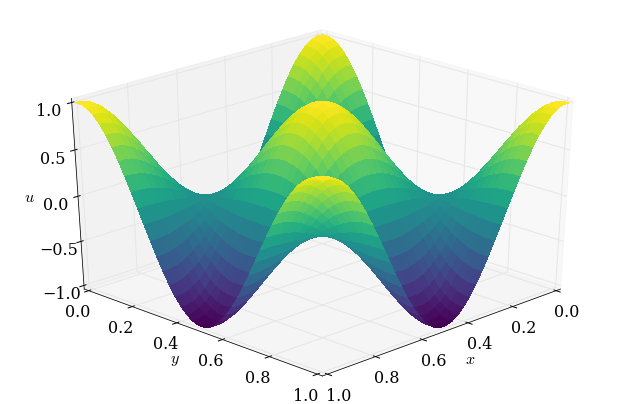

In [8]:
A40_SOR1=SOR(41,41,1,1e-9,1.9)
print('difference              error                 residual        iterations')
print(A40_SOR1[3:]) 
plot_3D(A40_SOR1[1],A40_SOR1[2],A40_SOR1[0])

/home/gil/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


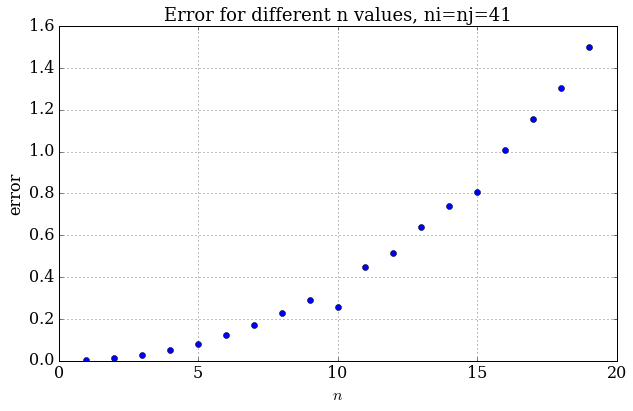

In [10]:
error40_jac_n=[]
for k in range(1,20):
    error40_jac_n.append(jacobi(41,41,k,1e-9)[4])
    
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$n$')
pyplot.ylabel('error')
pyplot.plot(numpy.linspace(1,19,19),error40_jac_n,'o')
pyplot.title('Error for different n values, ni=nj=41',fontsize=18)
pyplot.legend()

/home/gil/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


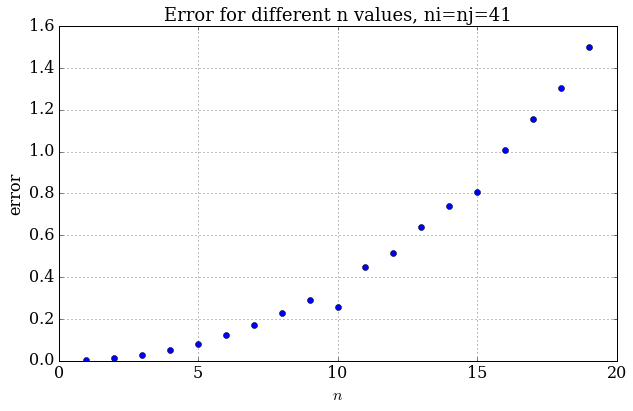

In [11]:
error40_SOR_n=[]
for k in range(1,20):
    error40_SOR_n.append(SOR(41,41,k,1e-9,1.9)[4])
    
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$n$')
pyplot.ylabel('error')
pyplot.plot(numpy.linspace(1,19,19),error40_SOR_n,'o')
pyplot.title('Error for different n values, ni=nj=41',fontsize=18)
pyplot.legend()

/home/gil/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


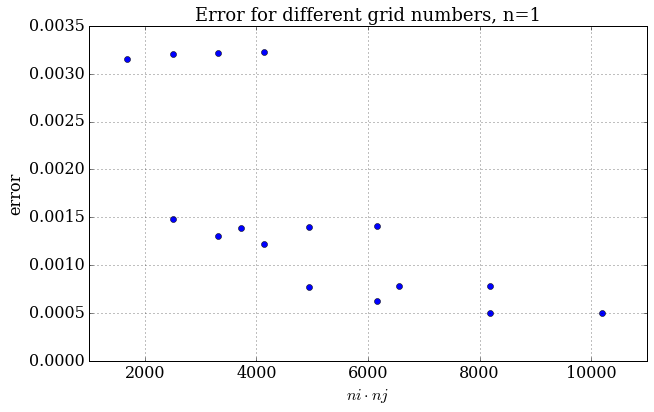

In [13]:
error_jac_grid=[]
ninj=[]
for ni in range(41,102,20):
    for nj in range(41,102,20):
        error_jac_grid.append(jacobi(ni,nj,1,1e-9)[4])
        ninj.append(ni*nj)
        
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$ni \cdot nj$')
pyplot.ylabel('error')
pyplot.plot(ninj,error_jac_grid,'o')
pyplot.title('Error for different grid numbers,Jacobi method, n=1',fontsize=18)
pyplot.legend()

/home/gil/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


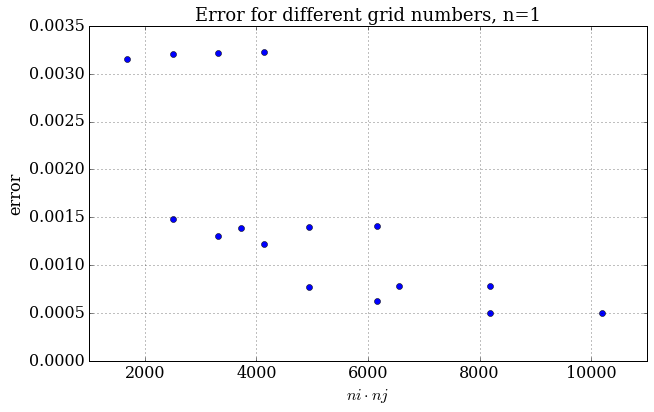

In [14]:
error_SOR_grid=[]
ninj=[]
for ni in range(41,102,20):
    for nj in range(41,102,20):
        error_SOR_grid.append(SOR(ni,nj,1,1e-9,1.9)[4])
        ninj.append(ni*nj)
        
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$ni \cdot nj$')
pyplot.ylabel('error')
pyplot.plot(ninj,error_SOR_grid,'o')
pyplot.title('Error for different grid numbers,SOR method, n=1',fontsize=18)
pyplot.legend()

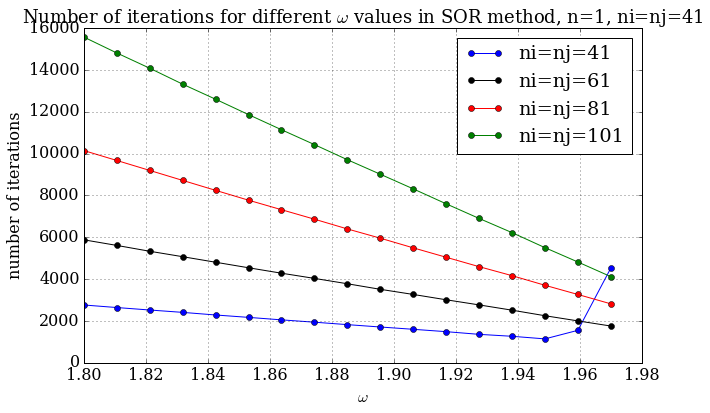

In [18]:
error40_SOR_omega=[]
error60_SOR_omega=[]
error80_SOR_omega=[]
error100_SOR_omega=[]
k=1.8
while k<1.97:
    error40_SOR_omega.append(SOR(41,41,1,1e-9,k)[6])
    error60_SOR_omega.append(SOR(61,61,1,1e-9,k)[6])
    error80_SOR_omega.append(SOR(81,81,1,1e-9,k)[6])
    error100_SOR_omega.append(SOR(101,101,1,1e-9,k)[6])
    k+=0.01
    
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$\omega$')
pyplot.ylabel('number of iterations')
pyplot.plot(numpy.linspace(1.8,1.97,(1.97-1.8)/0.01+1),error40_SOR_omega,color='b',marker='o')
pyplot.plot(numpy.linspace(1.8,1.97,(1.97-1.8)/0.01+1),error60_SOR_omega,color='k',marker='o')
pyplot.plot(numpy.linspace(1.8,1.97,(1.97-1.8)/0.01+1),error80_SOR_omega,color='r',marker='o')
pyplot.plot(numpy.linspace(1.8,1.97,(1.97-1.8)/0.01+1),error100_SOR_omega,color='g',marker='o')
pyplot.title('Number of iterations for different $\omega$ values in SOR method, n=1',fontsize=18)
pyplot.legend(['ni=nj=41','ni=nj=61','ni=nj=81','ni=nj=101']);